In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box
import nomad.io.base as loader
import nomad.city_gen as cg
from nomad.city_gen import City, Building, Street
import geopandas as gpd

## Load street geometries

In [31]:
streets = gpd.read_file("Streets_Arterials.geojson").to_crs("EPSG:3857")

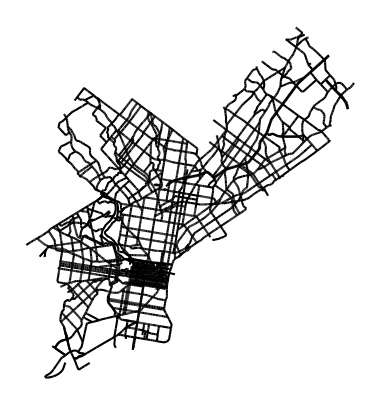

In [32]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_axis_off()

streets.plot(ax=ax, edgecolor="black")
plt.show()

## Bounding box for old city

In [33]:
bbox = box(-75.16620602283949, 39.94115823455355, -75.14565573634475, 39.955720193879245)
old_city = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:4326").to_crs("EPSG:3857")

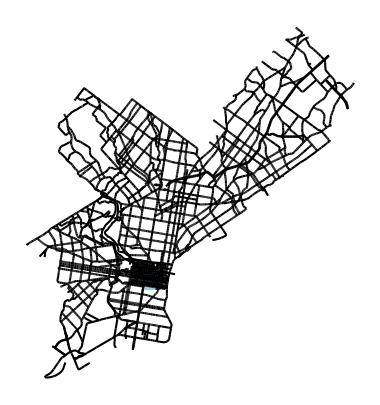

In [34]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_axis_off()

streets.plot(ax=ax, edgecolor="black")
old_city.plot(ax=ax, alpha=0.4)
plt.show()

## Clip streets to old city

<Axes: >

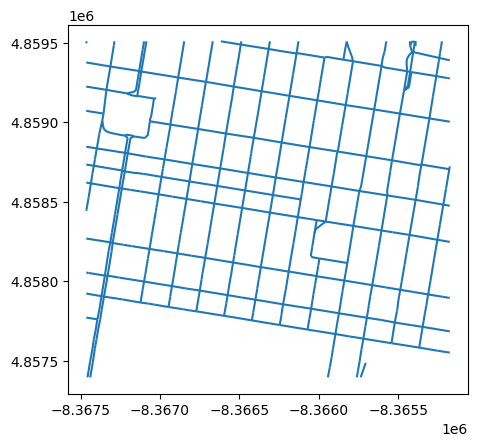

In [35]:
clipped_streets = gpd.clip(streets, old_city)
clipped_streets.plot()

In [25]:
bbox.centroid.coords.xy

(array('d', [-75.15593087959213]), array('d', [39.948439214216386]))

<Axes: >

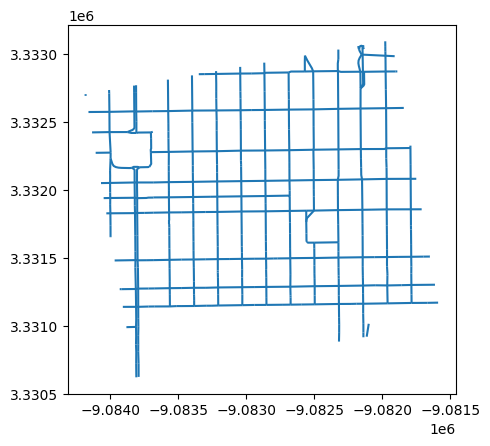

In [37]:
rot_streets = clipped_streets.assign(geometry=clipped_streets.geometry.rotate(10, origin=(-75.1559308, 39.948439214) ) )
rot_streets = gpd.GeoDataFrame(rot_streets)

rot_streets.plot()